# Генеративно-состязательные сети (Generative Adversarial Networks)

В задании предлагается реализовать GAN, обучить её на MNIST, оценить правдоподобие и сделать выводы.

Необходимая теория приведена ниже.

Актуальная версия доступна по адресу https://github.com/nadiinchi/dl_labs/blob/master/lab_gan.ipynb

## Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

## Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x \in \mathbb{R}^D$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. $x = G_\theta(z)$.

Параметры преобразования $G_\theta(z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z))$$

## Оценка логарифма правдоподобия
Для оценки логарифма правдоподобия используется метод Парзеновского окна/ядерного сглаживания (англ. Kernel Density Estimation/Parzen–Rosenblatt window method). Концептуально он заключается в том, что мы сглаживаем модельное распределение, и по этому сглаженному распределению вычисляем правдоподобие модели.

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z)) \approx \frac{1}{Mh^D}\sum_{i=1}^M K\left(\frac{x - G_\theta(z_i)}{h}\right)$$

Здесь $K(x)$ - любое распределение, а $h$ - ширина окна. Тогда выполняется

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{Mh^D}\sum_{j=1}^M K\left(\frac{x_i - G_\theta(z_j)}{h}\right)$$

В генеративно-состязательных сетях для оценки правдоподобия используется стандартное нормальное распределение $K(x) = N(x | 0, I)$. Тогда получаем

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{M}\sum_{j=1}^M \prod_{k=1}^D\frac{1}{\sqrt{2 \pi} \sigma}\exp\left(-\frac{(x_{i,k} - G(z_j)_k)^2}{2\sigma^2}\right)$$

Коэффициент $\sigma$ настраивается на валидационной выборке и с его помощью считается правдоподобие тестовой выборки.

### Загрузка, нормировка и визуалиация данных

In [29]:
import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

In [30]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255)
data = MNIST('mnist', download=True, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255)

C:\Apps\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Apps\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [31]:
digit_size = 14

In [32]:
train_data.tensors = (nn.AvgPool2d(2, 2)(train_data.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )
test_data_raw.tensors = (nn.AvgPool2d(2, 2)(test_data_raw.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )

In [33]:
valid_data = TensorDataset(test_data_raw.tensors[0][:5000])
test_data = TensorDataset(test_data_raw.tensors[0][5000:])

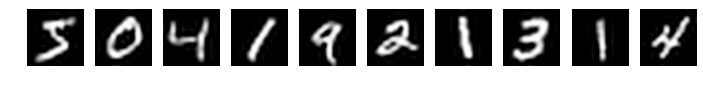

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, digit_size, digit_size)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

In [35]:
n = 15

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

### Функции и классы, описывающие модель и процесс её обучения

In [36]:
class Reshape(nn.Module):
    def __init__(self, *args):
        """
        Запоминает размерности, в которые при проходе
        вперед будут переводиться все объекты.
        Например,
            input = torch.zeros(100, 196)
            reshape_layer = Reshape(1, 14, 14)
            reshape_layer(input)
        возвращает тензор размерности (100, 1, 14, 14).
            input = torch.zeros(100, 1, 14, 14)
            reshape_layer = Reshape(-1)
            reshape_layer(input)
        наоборот вернет тензор размерности (100, 196).
        """
        super(type(self), self).__init__()
        self.dims = args
        

    def forward(self, input):
        """
        Возвращает тензор с измененными размерностями объектов.
        Вход: input, FloatTensor.
        Возвращаемое значение: FloatTensor.
        """
        return input.view(input.size(0), *self.dims)

In [57]:
class GAN(nn.Module):
    def __init__(self, d):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
       
        # Можно пробовать другие архитектуры: как более сложные
        # сверточные, так и более простые, например, полносвязные.
        # Однако желательно обучить хотя бы одну сверточную модель.
        self.discriminator = nn.Sequential(
            Reshape(1, 14, 14),
            nn.Conv2d(1, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, 2, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, 3, 1, 0, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            Reshape(-1),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        self.generator = nn.Sequential(
            Reshape(self.d, 1, 1),
            nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, 2, 1, 1, bias=False),
            Reshape(-1),
            nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x d.
        """
        # ваш код здесь
        
        z = torch.Tensor(np.random.normal(0 , 1 ,(num_samples,self.d)))
        if next(self.parameters()).is_cuda:
            z = z.cuda()
        return z

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x D.
        """
        z = torch.Tensor(np.random.normal(0 , 1 ,(num_samples,self.d)))
        if next(self.parameters()).is_cuda:
            z = z.cuda()
            
        return self.generator(z)
        

    def discriminator_loss(self, batch):
        """
        Вычисляет значение функции потерь дискриминатора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        дискриминатора на данном батче.
        """
        # ваш код здесь
        if next(self.parameters()).is_cuda:
            device = 'cuda'
        else :
            device = 'cpu'
        criterion = nn.BCELoss()
        bs = batch.size()[0]
        x_real, y_real = batch, torch.ones(bs, 1)
        x_real, y_real = x_real.to(device), y_real.to(device)
        D_output = self.discriminator(x_real)
        D_real_loss = criterion(D_output, y_real)
        #D_real_loss.backward()
        D_real_score = D_output
        
        x_fake, y_fake = self.generate_samples(bs).to(device), torch.zeros(bs, 1).to(device)
        D_output = self.discriminator(x_fake)
        D_fake_loss = criterion(D_output, y_fake)
        #D_fake_loss.backward()
        
        
        D_loss = D_real_loss + D_fake_loss
        
        
        return D_loss

    def generator_loss(self, batch_size):
        """
        Вычисляет значение функции потерь генератора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        генератора на данном батче.
        """
        if next(self.parameters()).is_cuda:
            device = 'cuda'
        else :
            device = 'cpu'
        criterion = nn.BCELoss()
        x, y = self.generate_samples(batch_size).to(device), torch.ones(batch_size, 1).to(device)
        D_output = self.discriminator(x)
        G_loss = criterion(D_output, y)
        
        return G_loss

In [38]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Tensor - матрица размера n x k.
    Возвращаемое значение: Tensor, вектор длины n.
    """
    
    return torch.log(torch.mean(torch.exp(mtx) , 1 ) + 1e-7)

In [102]:
a = torch.logspace(-4, 4, 100)
b = torch.argmax(a)
print(a.size())

torch.Size([100])


In [119]:
def likelihd (sigma , val , gen):
    a = torch.sum( -(val - gen)**2/(2*sigma**2) , 2 )
    a = log_mean_exp(a) - np.log((2*math.pi)**0.5 * sigma) 
    return a.mean().item()

In [120]:
def best_sigma(val , gen):
    sigma_space = np.logspace(-4, 4, 100)
    ll_history = np.zeros_like(sigma_space)
    
    
    for i , sigma in enumerate(sigma_space):
        ll_history[i] = likelihd(sigma , val , gen)
        
        
    return sigma_space[np.argmax(ll_history)]
    

In [99]:
def log_likelihood(generated_set, validation_set, test_set):
    """
    Возвращает оценку логарифма правдоподобия модели GAN методом
    Парзеновского окна со стандартным нормальным ядром.
    Подсказка: sigma должна настраиваться по валидационной выборке, а
    правдоподобие считаться по тестовой.
    Подсказка: вместо sigma можно настраивать log_sigma.
    Подсказка: для настойки sigma допустимо использовать как перебор по сетке,
    так и другие методы опимизации.
    Вход: generated_set - сэмплы из генеративной модели.
    Вход: validation_set - валидационная выборка.
    Вход: test_set - тестовая выборка.
    Возвращаемое значение: float (не Tensor!) - оценка логарифма правдоподобия.
    """
    G_size = generated_set.size()
    V_size = validation_set.size()
    T_size = test_set.size()
    
    #
    moded_gen = generated_set.repeat(V_size[0], 1 ,1)
    moded_val = validation_set.repeat(G_size[0] , 1 ,1).permute(1,0,2) #транспонируем для того чтобы было NxMxD а не МxNxD
    moded_test = test_set.repeat(G_size[0] , 1 ,1).permute(1,0,2)
    
    # настроим сигму просто перебором
    
    sigma = best_sigma(moded_val , moded_gen)
    likelihood = likelihd(sigma ,moded_val,moded_gen )
    
    return likelihood

In [92]:
def generate_many_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(model.generate_samples(min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0)

In [126]:
def train_model(model, num_epochs=100):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: k, int - число итераций оптимизации дискриминатора на итерацию оптимизации
    генератора.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'generator_losses' - список значений функции потерь генератора,
    'discriminator_losses' - список значений функции потерь дискриминатора.
    """
    if torch.cuda.is_available():
        model = model.cuda()
    model.train()

    # возможно, нужно подобрать другие параметры, чтобы модель обучилась
    batch_size = 64
    learning_rate = 2e-4

    # возможно, нужно использовать другие методы оптимизации или параметры методов оптимизации,
    # чтобы модель обучилась
    gd_generator = optim.Adam(model.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    gd_discriminator = optim.RMSprop(model.discriminator.parameters(), lr=learning_rate)

    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    total_batches = len(dataloader)

    generator_losses = [0]
    discriminator_losses = [0]
    log_likelihoods = []

    generated_samples = generate_many_samples(model, 512, batch_size).detach()
    valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
    valid_samples = valid_samples.to(next(model.parameters()).device)
    test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
    test_samples = test_samples.to(next(model.parameters()).device)
    ll = log_likelihood(generated_samples, valid_samples, test_samples)
    log_likelihoods.append(ll)
    print('Log-likelihood', ll, flush=True)

    for epoch in range(num_epochs):
        for i, (batch, ) in enumerate(dataloader):
            if torch.cuda.is_available():
                batch = batch.cuda()

            model.discriminator.zero_grad()
            discriminator_loss = model.discriminator_loss(batch)
            discriminator_loss.backward() #находится в функции лосса
            gd_discriminator.step()
            
            # Generator
            model.generator.zero_grad()
            generator_loss = model.generator_loss(batch_size)
            generator_loss.backward()
            gd_generator.step()
            
            
            # не забудьте корректно сохранить статистику
            discriminator_losses.append(float(discriminator_loss))
            generator_losses.append(float(generator_loss))

            if ( 1) % 100 == 0:
                print('\rEpoch:', epoch, 'G_loss:', generator_losses[-1],
                      'D_loss:', discriminator_losses[-1],
                      'Batch', i + 1, 'of', total_batches,
                      ' ' * 10, end='', flush=True)
        print(flush=True)
        generated_samples = generate_many_samples(model, 512, batch_size).detach()
        valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
        valid_samples = valid_samples.to(next(model.parameters()).device)
        test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
        test_samples = test_samples.to(next(model.parameters()).device)
        ll = log_likelihood(generated_samples, valid_samples, test_samples)
        log_likelihoods.append(ll)
        print('Log-likelihood', ll , flush=True)
        print('\rEpoch:', epoch, 'G_loss:', generator_losses[-1],
                      'D_loss:', discriminator_losses[-1],
                      'Batch',  end='', flush=True)

    return {
        'model': model.cpu(),
        'generator_losses': generator_losses,
        'discriminator_losses': discriminator_losses,
        'log_likelihoods': log_likelihoods
    }

### Обучение модели

In [125]:
# Подсказка: обучать GANs с скрытой размерностью 2 непросто,
# для этого требуется очень аккуратно подобрать хаки/процесс обучения/
# /архитектуру модели/инициализацию.
# Если не получается сразу, стоит обучить GANs с бОльшей скрытой размерностью,
# а затем вернуться к этой ячейке.
g2 = GAN(2)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d2 = train_model(g2, num_epochs=3)

Log-likelihood -3.2886786460876465

Log-likelihood
Epoch: 0 G_loss: 0.7567218542098999 D_loss: 1.4130580425262451 Batch
Log-likelihood
Epoch: 1 G_loss: 0.9039075374603271 D_loss: 1.3807005882263184 Batch
Log-likelihood
Epoch: 2 G_loss: 0.8795472383499146 D_loss: 1.2670780420303345 BatchWall time: 1min 47s


In [131]:
g10 = GAN(10)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d10 = train_model(g10, num_epochs=30)

Log-likelihood -3.2835147380828857

Log-likelihood -2.940824031829834
Epoch: 0 G_loss: 0.719717264175415 D_loss: 1.363433837890625 Batch
Log-likelihood -2.862443208694458
Epoch: 1 G_loss: 0.7208279967308044 D_loss: 1.328920841217041 Batch
Log-likelihood -2.8795852661132812
Epoch: 2 G_loss: 0.7290041446685791 D_loss: 1.3379175662994385 Batch
Log-likelihood -2.906832218170166
Epoch: 3 G_loss: 0.7827088236808777 D_loss: 1.2918877601623535 Batch
Log-likelihood -2.891388177871704
Epoch: 4 G_loss: 0.820635199546814 D_loss: 1.3852031230926514 Batch
Log-likelihood -2.9006762504577637
Epoch: 5 G_loss: 0.7838245630264282 D_loss: 1.333532691001892 Batch
Log-likelihood -2.9025051593780518
Epoch: 6 G_loss: 0.8073563575744629 D_loss: 1.338762879371643 Batch
Log-likelihood -2.878167152404785
Epoch: 7 G_loss: 0.768634557723999 D_loss: 1.3306162357330322 Batch
Log-likelihood -2.8891303539276123
Epoch: 8 G_loss: 0.7931700348854065 D_loss: 1.2408339977264404 Batch
Log-likelihood -2.872744083404541
Epoch:

In [132]:
g100 = GAN(100)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d100 = train_model(g100, num_epochs=30)

Log-likelihood -3.328871011734009

Log-likelihood -3.1263017654418945
Epoch: 0 G_loss: 0.7915540933609009 D_loss: 1.1746280193328857 Batch
Log-likelihood -2.9031355381011963
Epoch: 1 G_loss: 0.8679825663566589 D_loss: 1.3029183149337769 Batch
Log-likelihood -2.927031993865967
Epoch: 2 G_loss: 0.8174598813056946 D_loss: 1.2452828884124756 Batch
Log-likelihood -2.9188437461853027
Epoch: 3 G_loss: 0.9205445051193237 D_loss: 1.2423596382141113 Batch
Log-likelihood -2.9233179092407227
Epoch: 4 G_loss: 0.9474581480026245 D_loss: 1.0455962419509888 Batch
Log-likelihood -2.9002845287323
Epoch: 5 G_loss: 0.8419243693351746 D_loss: 1.1195216178894043 Batch
Log-likelihood -2.9114136695861816
Epoch: 6 G_loss: 1.0033926963806152 D_loss: 1.1476787328720093 Batch
Log-likelihood -2.9025862216949463
Epoch: 7 G_loss: 0.8339685201644897 D_loss: 1.2227959632873535 Batch
Log-likelihood -2.887144088745117
Epoch: 8 G_loss: 0.9353326559066772 D_loss: 1.1164108514785767 Batch
Log-likelihood -2.8781609535217285

### Анализ результатов

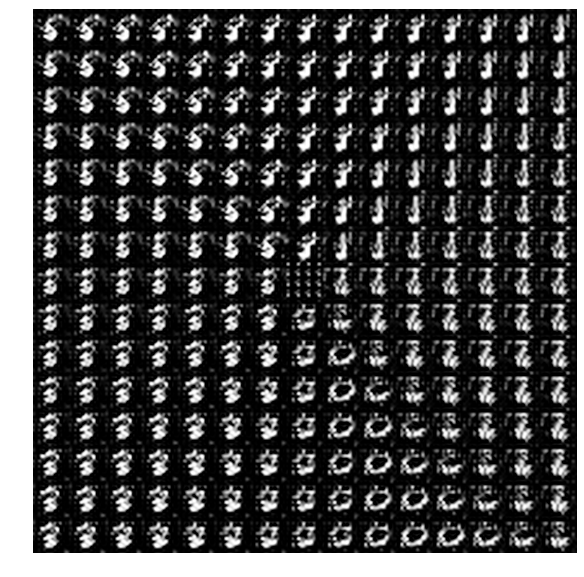

In [153]:
def draw_manifold_gan(model):
    generator = lambda z: model.generator(torch.from_numpy(z).float()).view(digit_size, digit_size).data.numpy()
    return draw_manifold(generator)

draw_manifold_gan(gan_model_d2['model'])

# наблюдалась явная невоспроизводимость, к сожалению не удалось сохранить лучшие результаты, поэтому прилагаю результаты двух обучений (количество эпох и архитектура не менялсь)

## 1

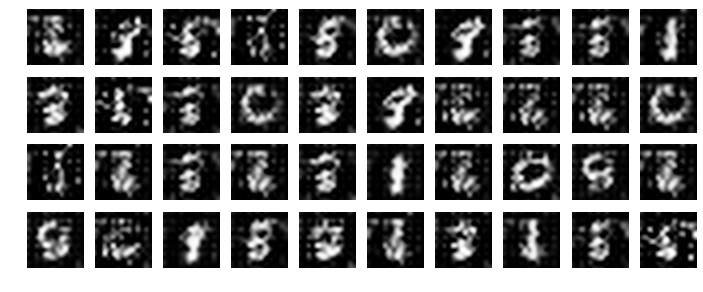

In [127]:
show_images(gan_model_d2['model'].generate_samples(40))

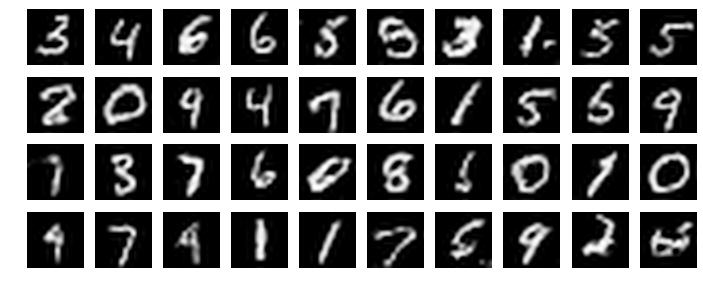

In [38]:
show_images(gan_model_d10['model'].generate_samples(40))

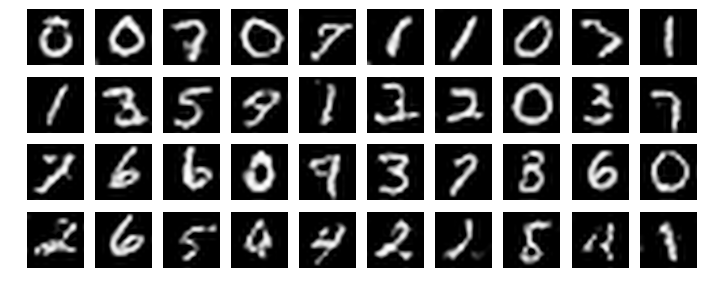

In [39]:
show_images(gan_model_d100['model'].generate_samples(40))

## 2

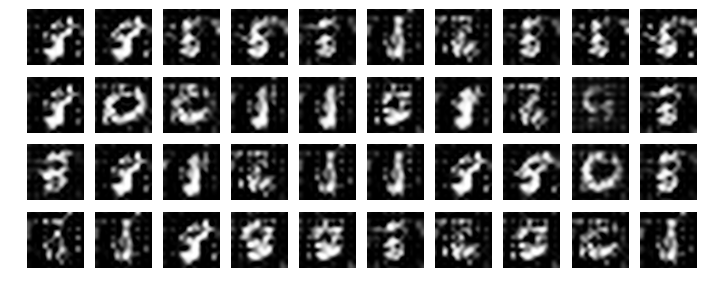

In [138]:
show_images(gan_model_d2['model'].generate_samples(40))

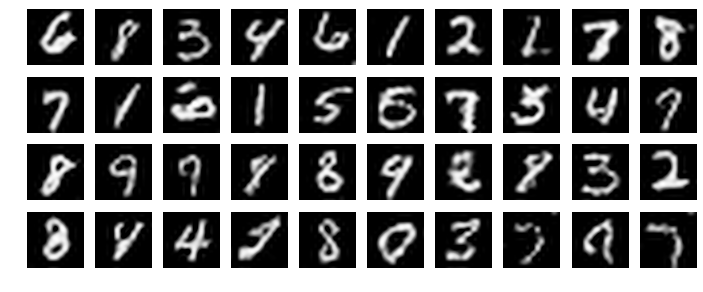

In [139]:
show_images(gan_model_d10['model'].generate_samples(40))

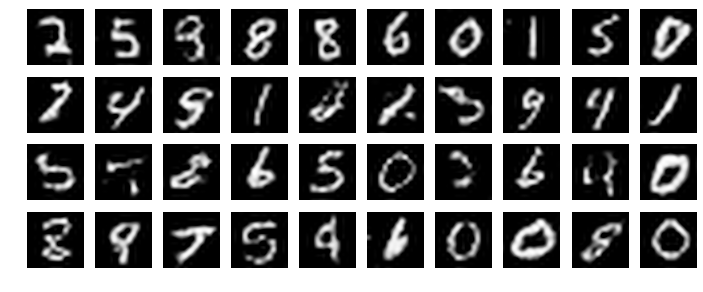

In [141]:
show_images(gan_model_d100['model'].generate_samples(40))

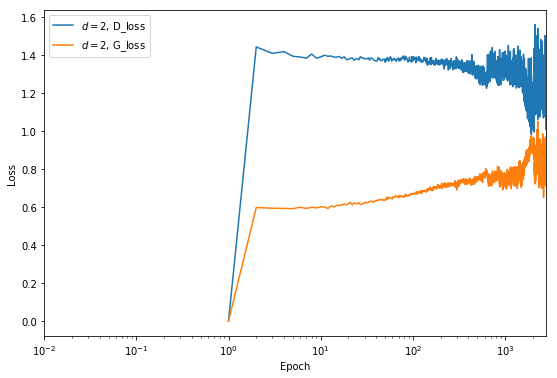

In [142]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, D_loss', 'discriminator_losses', gan_model_d2),
    ('$d = 2$, G_loss', 'generator_losses', gan_model_d2),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) 
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

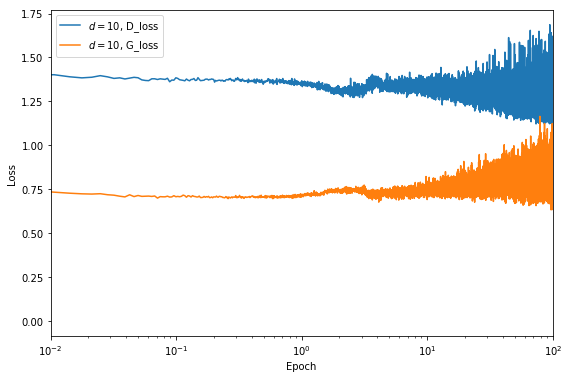

In [135]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 10$, D_loss', 'discriminator_losses', gan_model_d10),
    ('$d = 10$, G_loss', 'generator_losses', gan_model_d10),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

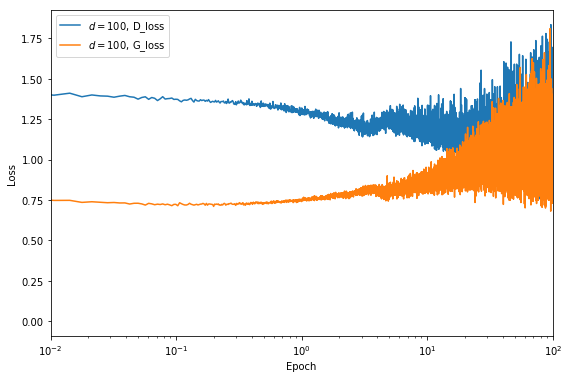

In [136]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 100$, D_loss', 'discriminator_losses', gan_model_d100),
    ('$d = 100$, G_loss', 'generator_losses', gan_model_d100),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

In [154]:
generated_samples = generate_many_samples(gan_model_d2['model'], 92, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

Wall time: 1min 15s


-2.786661148071289

In [155]:
generated_samples = generate_many_samples(gan_model_d10['model'], 92, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

Wall time: 1min 14s


-2.8481597900390625

In [156]:
generated_samples = generate_many_samples(gan_model_d100['model'], 92, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

Wall time: 1min 11s


-2.8356850147247314

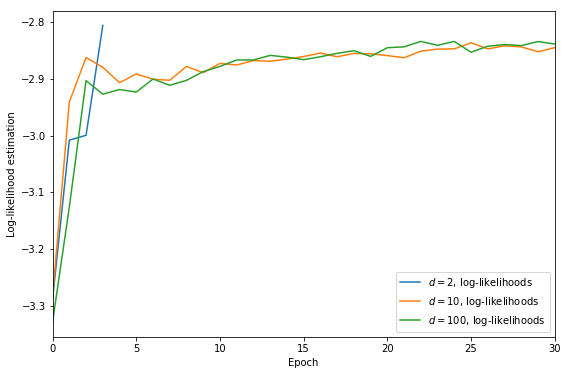

In [137]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, log-likelihoods', 'log_likelihoods', gan_model_d2),
    ('$d = 10$, log-likelihoods', 'log_likelihoods', gan_model_d10),
    ('$d = 100$, log-likelihoods', 'log_likelihoods', gan_model_d100),
]:
    data = model[name]
    x_labels = np.arange(len(data))
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.0, xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы
Место для ваших выводов, наблюдений, гипотез.